In [741]:
!pip install git+https://github.com/danielegerbaldo/Mathematics-of-Epidemics-on-Networks.git

  Cloning https://github.com/danielegerbaldo/Mathematics-of-Epidemics-on-Networks.git to c:\users\daniele\appdata\local\temp\pip-req-build-pzfe9m1o


  Running command git clone -q https://github.com/danielegerbaldo/Mathematics-of-Epidemics-on-Networks.git 'C:\Users\Daniele\AppData\Local\Temp\pip-req-build-pzfe9m1o'


In [742]:
import networkx as nx
import matplotlib.pyplot as plt
import statistics
import sys
import random
import math
import EoN
import numpy as np
import powerlaw
import pandas as pd
import seaborn as sns
from collections import defaultdict
from scipy.integrate import odeint
from itertools import chain, combinations
from scipy.cluster.hierarchy import dendrogram
from collections import Counter
from scipy.stats import norm
from termcolor import colored, cprint
from matplotlib.patches import Rectangle

In [743]:
MORENO_RESIDENCE_HALL_FILE = 'networks/moreno_residence_hall.txt'

# Residence-Hall-Network

(Directed)

This directed network contains friendship ratings between 217 residents living at a residence hall located on the Australian National University campus. A node represents a person and 
an edge represents a friendship tie.  The friendships are weighted as follows from strongest to weakest tie:  5 (best friend), 4 (close friend), 3 (friend), 2, 1.

In [744]:
G = nx.read_weighted_edgelist(MORENO_RESIDENCE_HALL_FILE, create_using= nx.DiGraph, nodetype=int)
cprint(nx.info(G),'green')

DiGraph with 217 nodes and 2672 edges


In [745]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
nodes = G.nodes()
edges = G.edges()

# Utility Functions

In [773]:
# def display_timeseries(t,ts_plots,data,title=None):
#     fig_time = plt.figure(figsize=(30,10))
#     data._display_time_series_(t=t,fig=fig_time,ts_plots = ts_plots, ts_list = None,timelabel=r'$t$') 
#     fig_time.suptitle(title,x=0.72,fontsize=16,fontweight='bold')
#     plt.show()
#     plt.close(fig_time)

def display_graph(t,pos,data):
    kwargs = { 'pos':pos,'node_size':8000}
    network_ax, timeseries_axes = data.display(t,ts_plots=[], **kwargs)
    plt.show()
    plt.close()

def display_linegraph(t, S, I, R=None,title=None):
    fig_sirs_ax = plt.figure(figsize=(30,10))
    plt.plot(t, S, label = 'Susceptible', color='green')
    plt.plot(t, I, label = 'Infected', color='red')
    if R is not None: plt.plot(t, R, label = 'Recovered', color='grey')
    plt.xlabel('t')
    plt.ylabel('Nodes')
    plt.legend()
    plt.title(title,fontsize=16,fontweight='bold')
    plt.show()
    plt.close(fig_sirs_ax)        
    

In [747]:
def get_random_nodes(i,r=None,vaxed=None):

    random_infected = []
    while(len(random_infected)<i):
        rand_node=random.randrange(1,217)
        if(vaxed==None):
            if rand_node not in random_infected:
                random_infected.append(rand_node)
        else:
            if rand_node not in random_infected and rand_node not in vaxed:
                random_infected.append(rand_node)

    if(r==None):        
        return random_infected
    else:
        random_recovered=[]
        while(len(random_recovered)<r):
            rand_rec_node=random.randrange(1,217)
            if rand_rec_node not in random_infected and rand_rec_node not in random_recovered:
                random_recovered.append(rand_rec_node)
        return random_infected,random_recovered

def get_infected(data):
    list_infected=[]

    for node in G.nodes():
        t,d = data.node_history(node)
        if 'I' in d:
            if not node in list_infected:
                list_infected.append(node)
    return list_infected            

### Sars-Cov-2 virus characteristics:

In [775]:
#R0 estimation study: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8436367/ https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8212592/
#Recovery rate study: https://www.nature.com/articles/s41467-020-20568-4

average_out_degree = statistics.mean([G.out_degree(n) for n in G.nodes])

#transmission rate per edge (probability of pass the disease to each of its susceptible neighbors)
original_cov_tau = 2.79/average_out_degree
alpha_cov_tau = 3.60/average_out_degree
delta_cov_tau = 5.08/average_out_degree

gamma = 1/8 #recovery rate per node (number of step when node is infected)

n_initial_infected = 1


# SIR

In [749]:
# Documentation: https://epidemicsonnetworks.readthedocs.io/en/latest/functions/EoN.fast_SIR.html#EoN.fast_SIR

## Snapshot at time t

In [750]:
pos=nx.spring_layout(G, k=0.6, iterations=50)
# display_graph(0.1,pos,sir_data)

## Time series

### Random infected nodes with Sars-Cov-2:

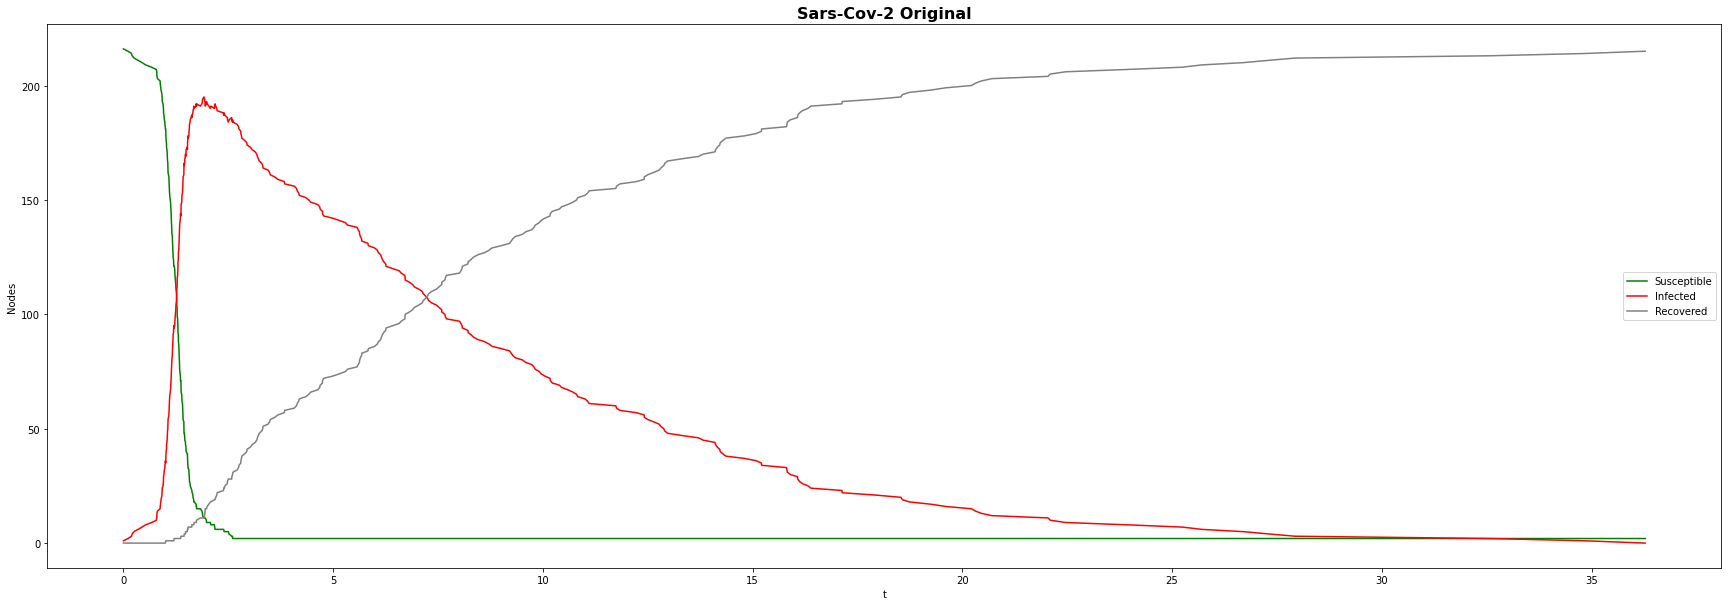

Peak: 195
Number of infected at least once: 215


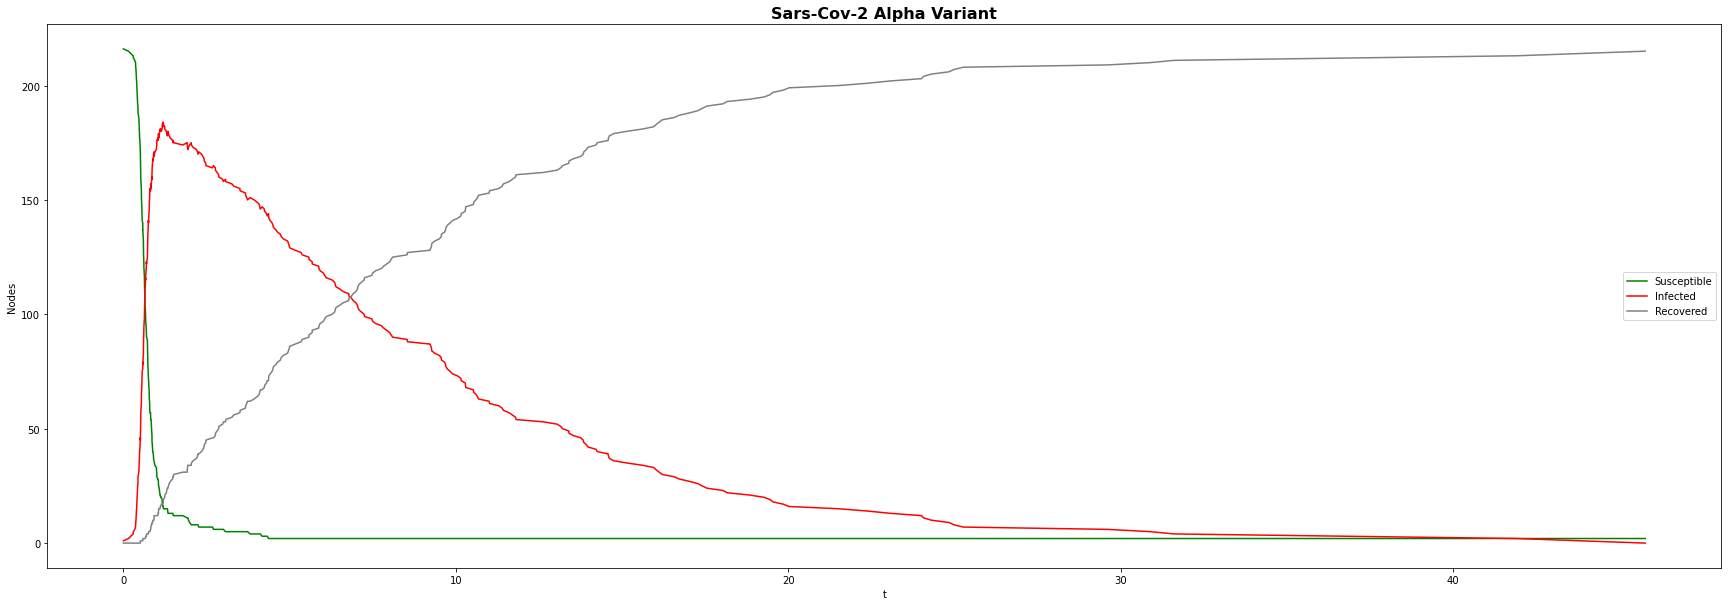

Peak: 184
Number of infected at least once: 215


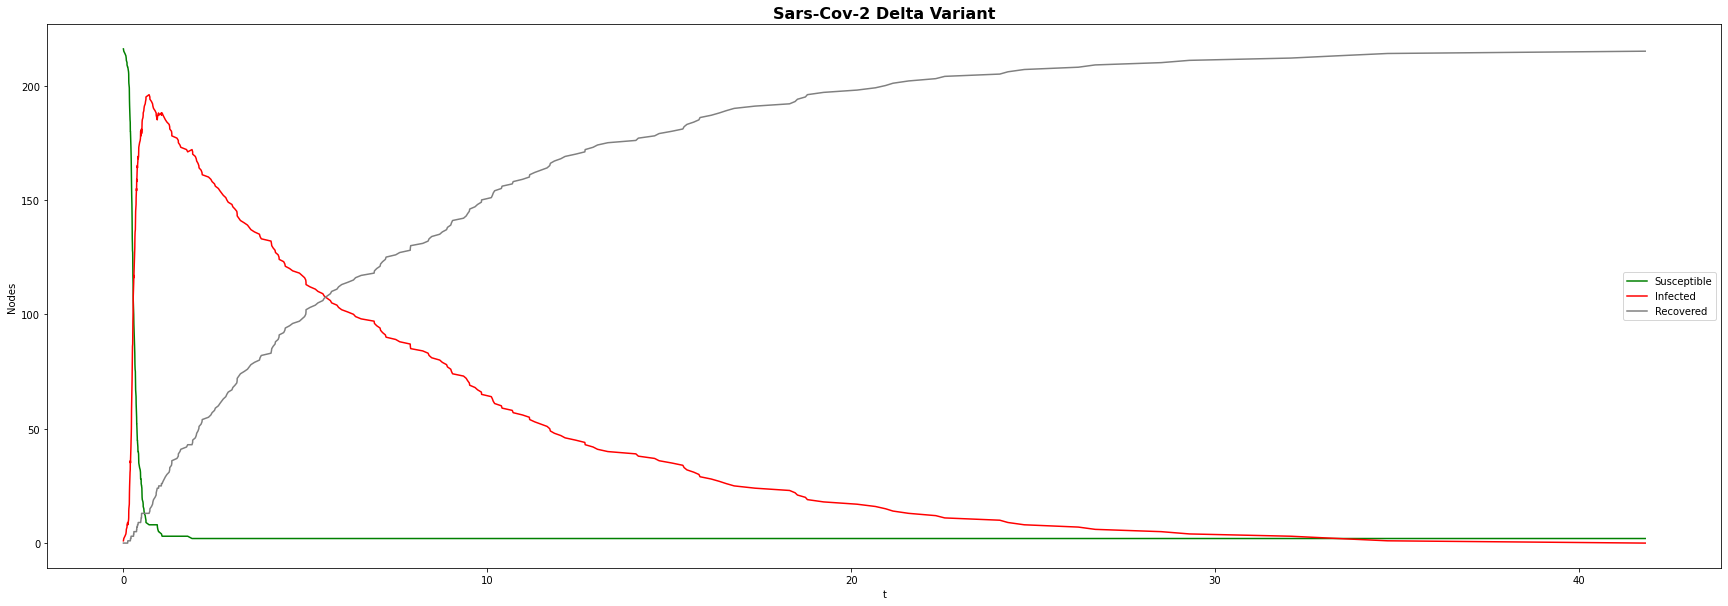

Peak: 196
Number of infected at least once: 215


In [776]:
sir_data_orig = EoN.fast_SIR(G, original_cov_tau, gamma, transmission_weight='weight',initial_infecteds=get_random_nodes(n_initial_infected), return_full_data=True, tmax=50)
sir_data_alpha = EoN.fast_SIR(G, alpha_cov_tau, gamma, transmission_weight='weight',initial_infecteds=get_random_nodes(n_initial_infected), return_full_data=True, tmax=50)
sir_data_delta = EoN.fast_SIR(G, delta_cov_tau, gamma, transmission_weight='weight',initial_infecteds=get_random_nodes(n_initial_infected), return_full_data=True, tmax=50)

display_linegraph(sir_data_orig.t(),sir_data_orig.S(),sir_data_orig.I(),sir_data_orig.R(),"Sars-Cov-2 Original")
print("Peak: " + str(max(sir_data_orig.I())))
print("Number of infected at least once: " + str(len(get_infected(sir_data_orig))))

display_linegraph(sir_data_alpha.t(),sir_data_alpha.S(),sir_data_alpha.I(),sir_data_alpha.R(),"Sars-Cov-2 Alpha Variant")
print("Peak: " + str(max(sir_data_alpha.I())))
print("Number of infected at least once: " + str(len(get_infected(sir_data_alpha))))

display_linegraph(sir_data_delta.t(),sir_data_delta.S(),sir_data_delta.I(),sir_data_delta.R(),"Sars-Cov-2 Delta Variant")
print("Peak: " + str(max(sir_data_delta.I())))
print("Number of infected at least once: " + str(len(get_infected(sir_data_delta))))

### Infecting hub first:

In [752]:
#Getting hub with highter out degree
H = G.copy()
max_out_degree_nodes = []
for node in G.nodes():
    if(len(max_out_degree_nodes)<7):
        max_out_degree_nodes.append(max(H.nodes, key=H.out_degree))
        H.remove_node(max(H.nodes, key=H.out_degree))

cprint('Out-Degree Hubs:', 'blue', end=' ')
cprint(max_out_degree_nodes,'green')

Out-Degree Hubs: [70, 184, 113, 120, 169, 27, 128]


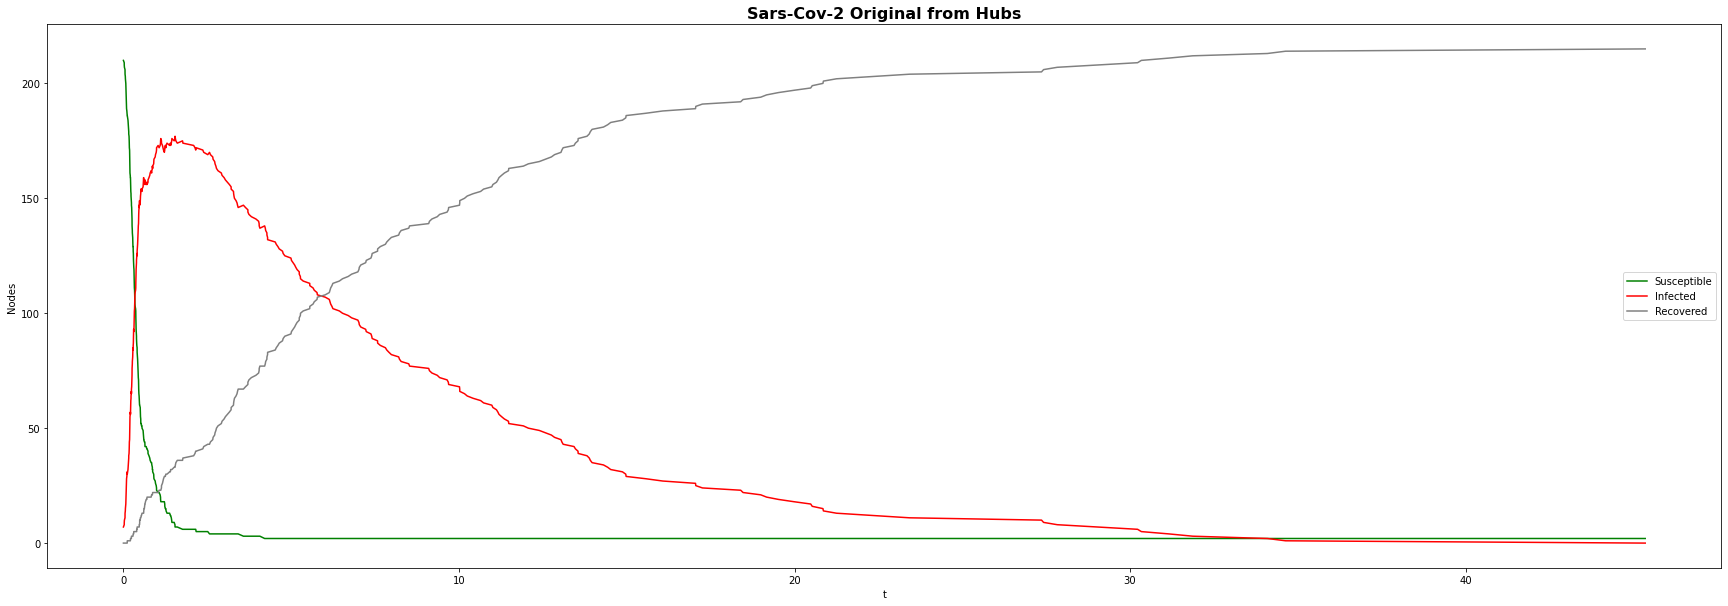

Peak: 177
Number of infected at least once: 215


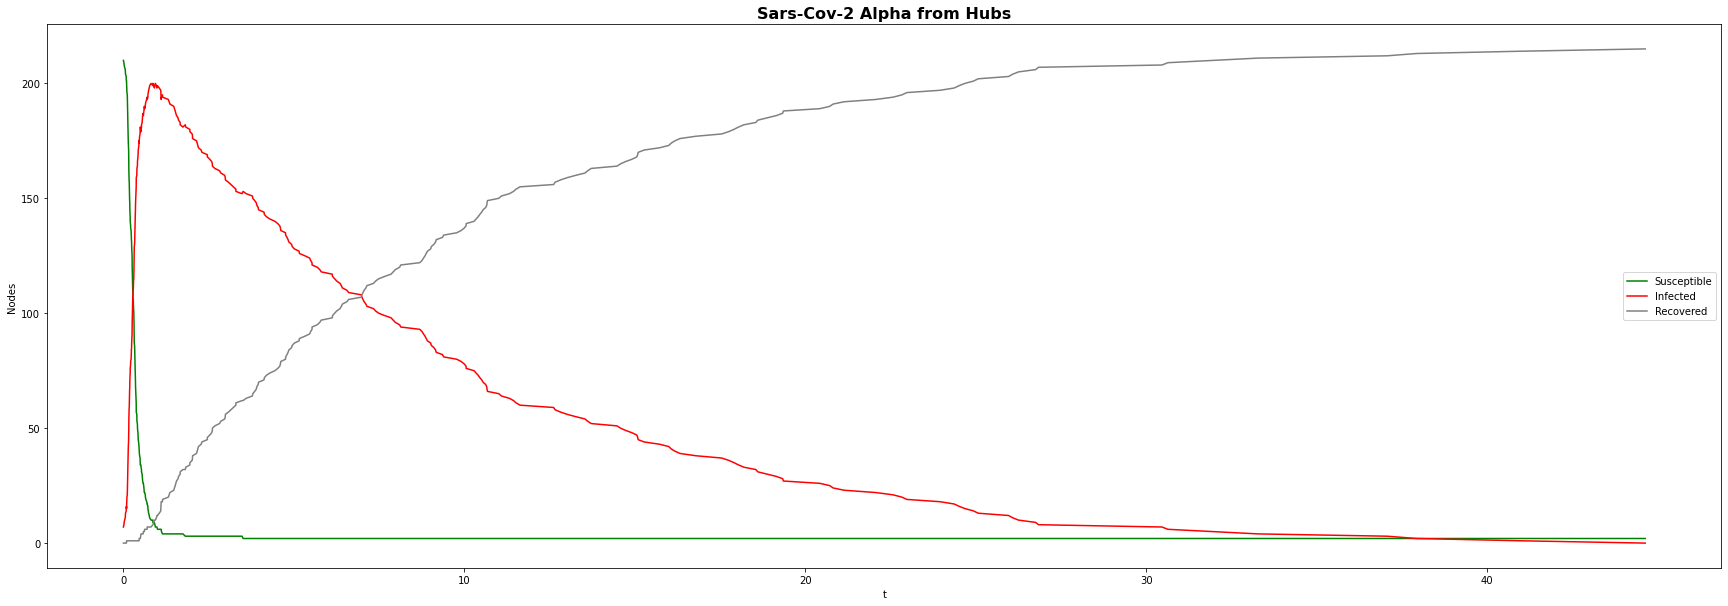

Peak: 200
Number of infected at least once: 215


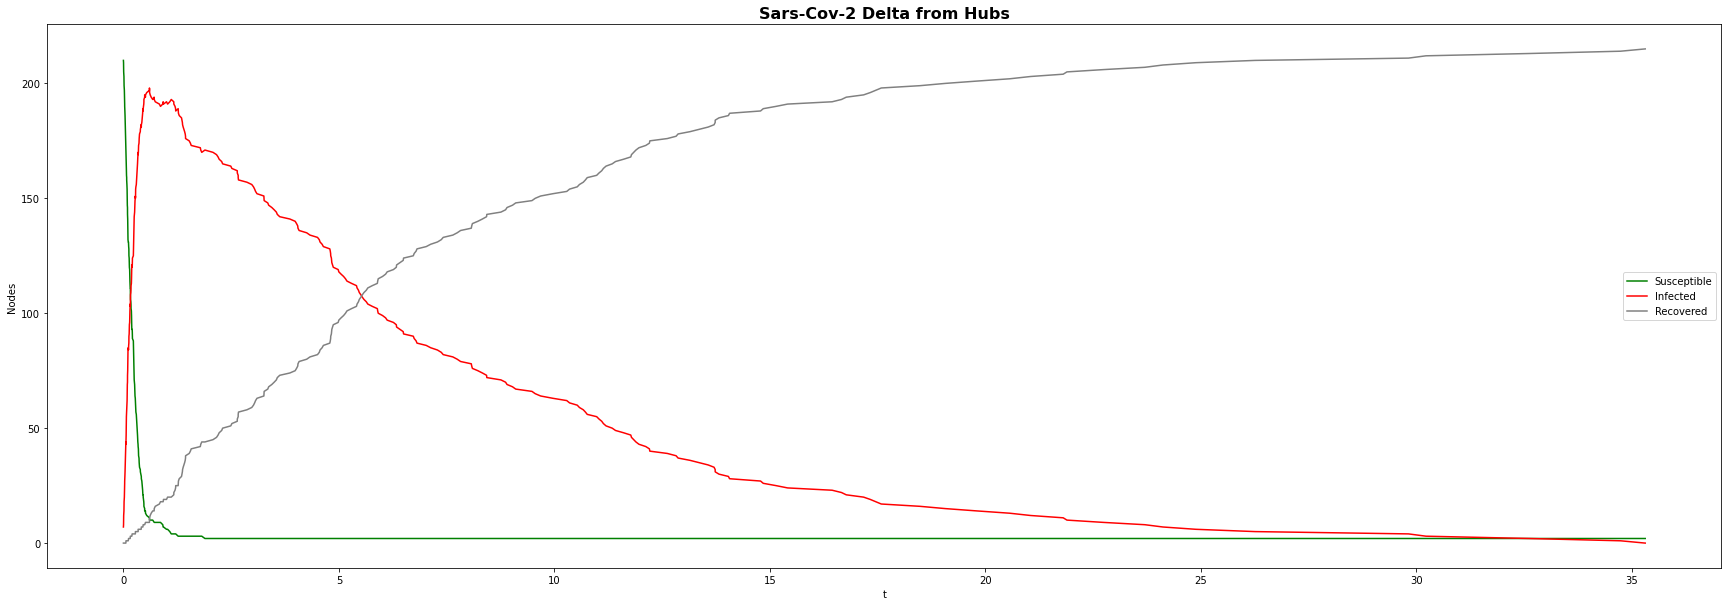

Peak: 198
Number of infected at least once: 215


In [753]:
#display_graph(0.1,pos,sir_data_hub)

sir_data_orig_hub = EoN.fast_SIR(G, original_cov_tau, gamma, transmission_weight='weight',initial_infecteds=max_out_degree_nodes, return_full_data=True, tmax=50)
sir_data_alpha_hub = EoN.fast_SIR(G, alpha_cov_tau, gamma, transmission_weight='weight',initial_infecteds=max_out_degree_nodes, return_full_data=True, tmax=50)
sir_data_delta_hub = EoN.fast_SIR(G, delta_cov_tau, gamma, transmission_weight='weight',initial_infecteds=max_out_degree_nodes, return_full_data=True, tmax=50)

display_linegraph(sir_data_orig_hub.t(),sir_data_orig_hub.S(),sir_data_orig_hub.I(),sir_data_orig_hub.R(),"Sars-Cov-2 Original from Hubs")
print("Peak: " + str(max(sir_data_orig_hub.I())))
print("Number of infected at least once: " + str(len(get_infected(sir_data_orig_hub))))

display_linegraph(sir_data_alpha_hub.t(),sir_data_alpha_hub.S(),sir_data_alpha_hub.I(),sir_data_alpha_hub.R(),"Sars-Cov-2 Alpha from Hubs")
print("Peak: " + str(max(sir_data_alpha_hub.I())))
print("Number of infected at least once: " + str(len(get_infected(sir_data_alpha_hub))))

display_linegraph(sir_data_delta_hub.t(),sir_data_delta_hub.S(),sir_data_delta_hub.I(),sir_data_delta_hub.R(),"Sars-Cov-2 Delta from Hubs")
print("Peak: " + str(max(sir_data_delta_hub.I())))
print("Number of infected at least once: " + str(len(get_infected(sir_data_delta_hub))))

### Vaccinate hub first

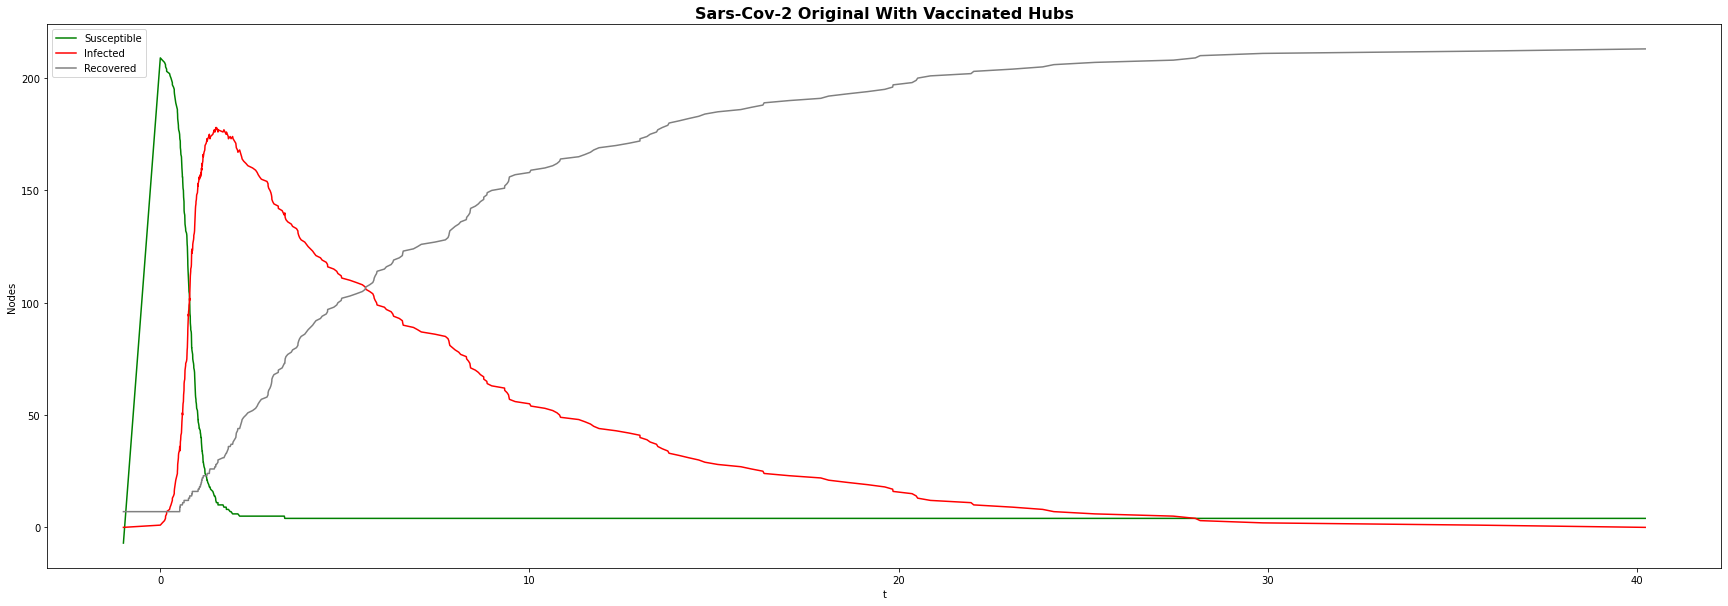

Peak: 178
Number of infected at least once: 206


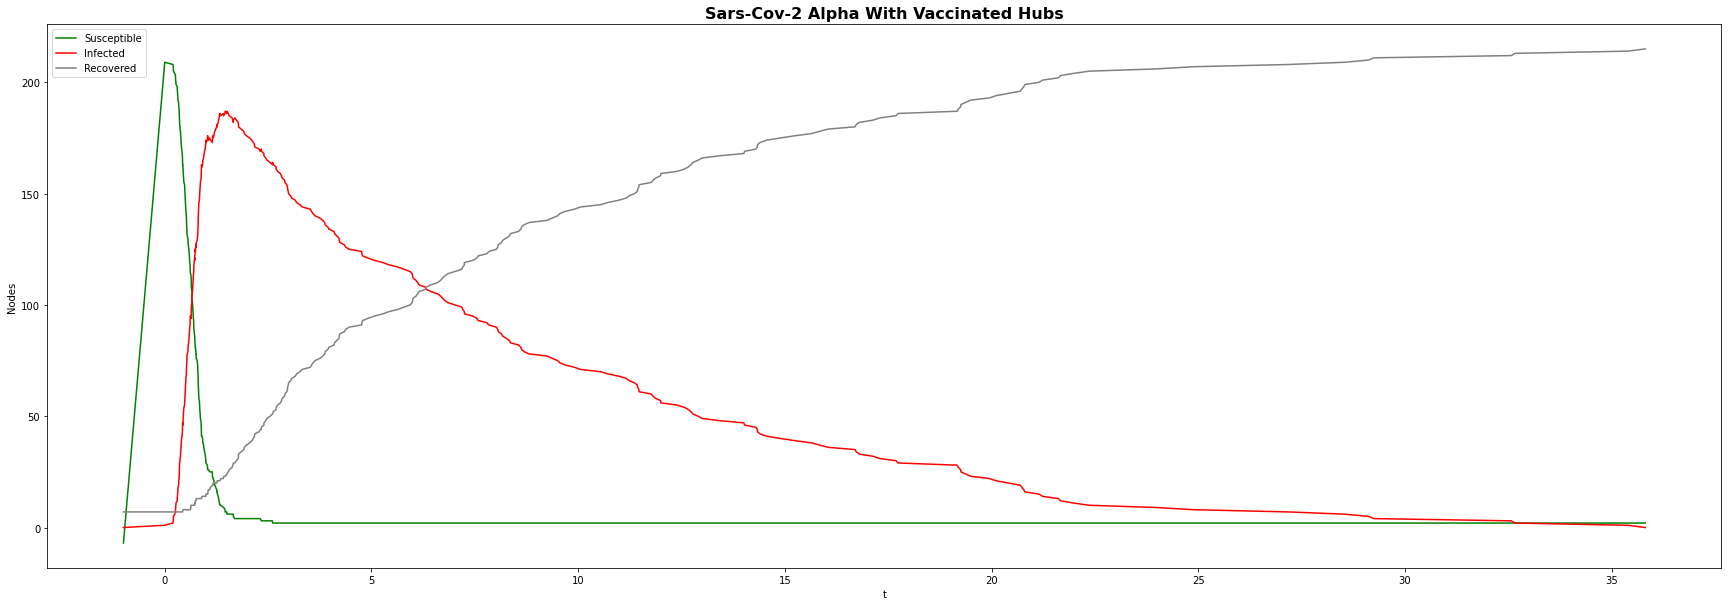

Peak: 187
Number of infected at least once: 208


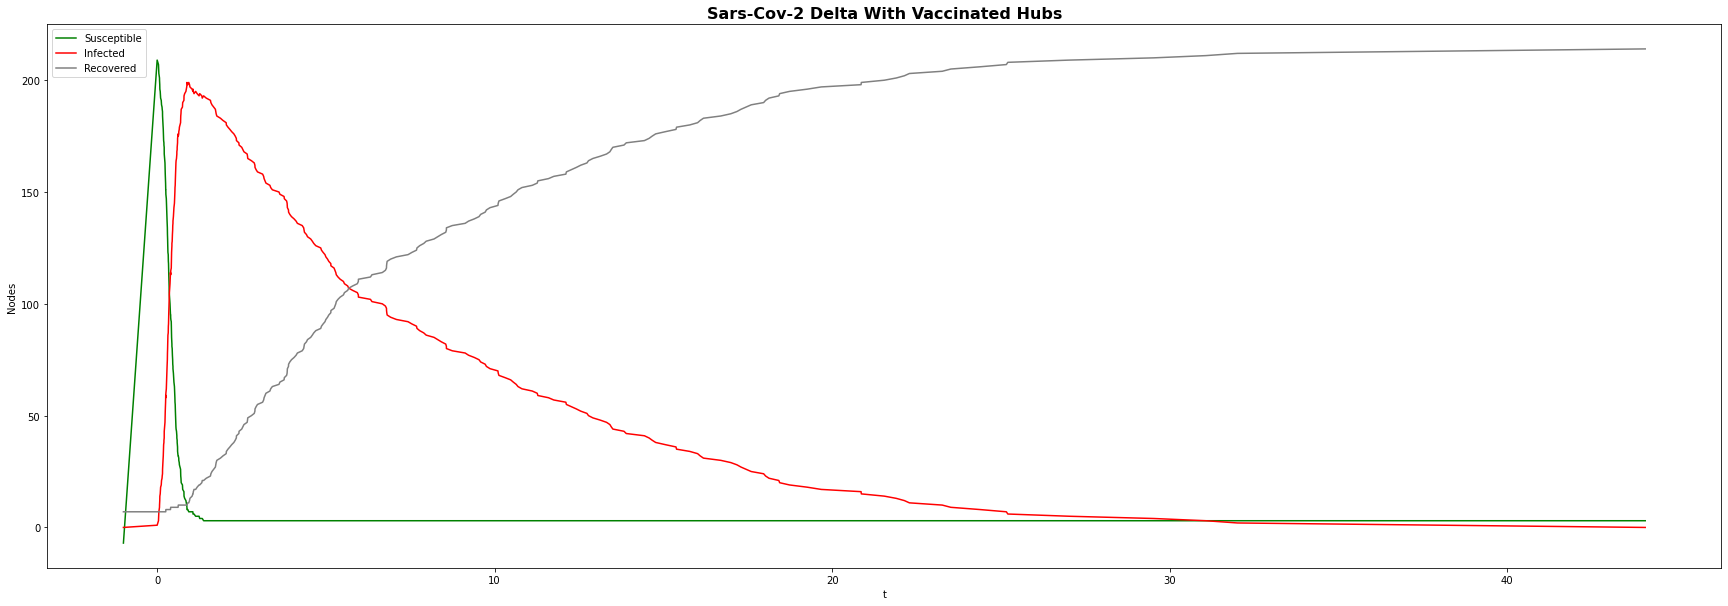

Peak: 199
Number of infected at least once: 207


In [777]:
#display_graph(0,pos,sir_data_hub_out_seq)

sir_data_orig_hub_vax = EoN.fast_SIR(G, original_cov_tau, gamma, transmission_weight='weight',initial_infecteds=get_random_nodes(n_initial_infected), initial_recovereds=max_out_degree_nodes,return_full_data=True, tmax=50)
sir_data_alpha_hub_vax = EoN.fast_SIR(G, alpha_cov_tau, gamma, transmission_weight='weight',initial_infecteds=get_random_nodes(n_initial_infected), initial_recovereds=max_out_degree_nodes,return_full_data=True, tmax=50)
sir_data_delta_hub_vax = EoN.fast_SIR(G, delta_cov_tau, gamma, transmission_weight='weight',initial_infecteds=get_random_nodes(n_initial_infected), initial_recovereds=max_out_degree_nodes,return_full_data=True, tmax=50)

display_linegraph(sir_data_orig_hub_vax.t(),sir_data_orig_hub_vax.S(),sir_data_orig_hub_vax.I(),sir_data_orig_hub_vax.R(),"Sars-Cov-2 Original With Vaccinated Hubs")
print("Peak: " + str(max(sir_data_orig_hub_vax.I())))
print("Number of infected at least once: " + str(len(get_infected(sir_data_orig_hub_vax))))

display_linegraph(sir_data_alpha_hub_vax.t(),sir_data_alpha_hub_vax.S(),sir_data_alpha_hub_vax.I(),sir_data_alpha_hub_vax.R(),"Sars-Cov-2 Alpha With Vaccinated Hubs")
print("Peak: " + str(max(sir_data_alpha_hub_vax.I())))
print("Number of infected at least once: " + str(len(get_infected(sir_data_alpha_hub_vax))))

display_linegraph(sir_data_delta_hub_vax.t(),sir_data_delta_hub_vax.S(),sir_data_delta_hub_vax.I(),sir_data_delta_hub_vax.R(),"Sars-Cov-2 Delta With Vaccinated Hubs")
print("Peak: " + str(max(sir_data_delta_hub_vax.I())))
print("Number of infected at least once: " + str(len(get_infected(sir_data_delta_hub_vax))))

## Animation

In [755]:
# #pos=nx.spring_layout(G, k=0.6, iterations=50)
# #pos= nx.kamada_kawai_layout(G)
# kwargs = { 'pos':pos,'node_size':8000}
# ani = sir_data_hub.animate(ts_plots=[],**kwargs)
# ani.save('SIRHub.mp4', fps=1, extra_args=['-vcodec', 'libx264'])

# SIS

In [756]:
# Documentation: https://epidemicsonnetworks.readthedocs.io/en/latest/examples/SIS_display.html

## Time series

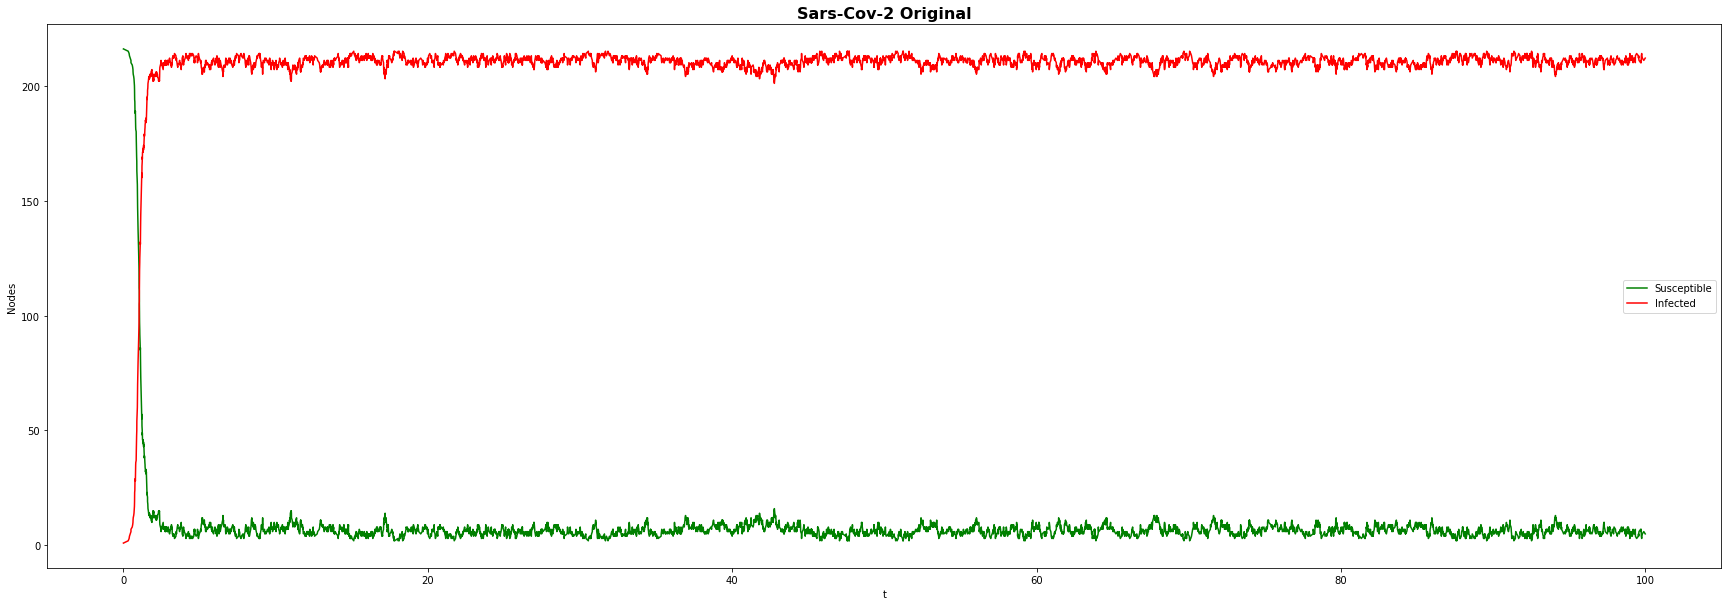

Peak: 215
Number of infected at least once: 215


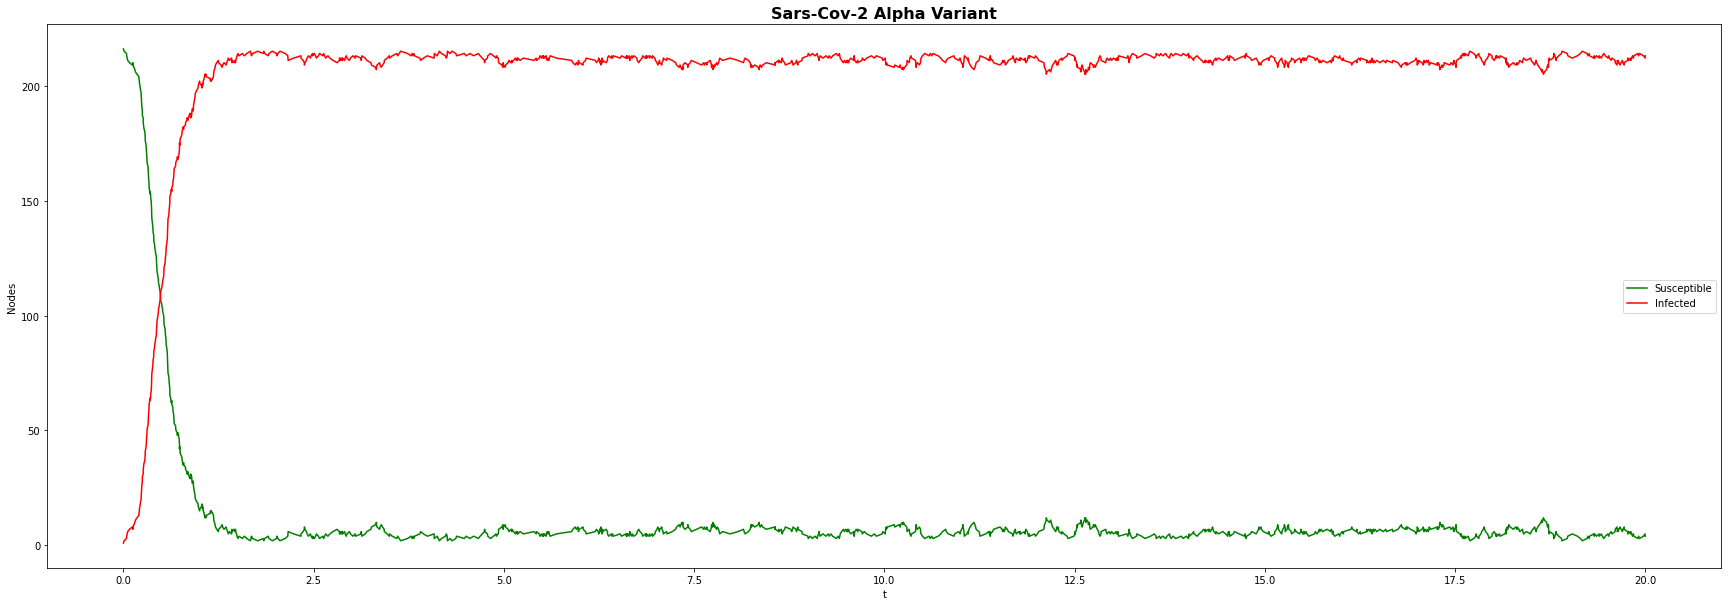

Peak: 215
Number of infected at least once: 215


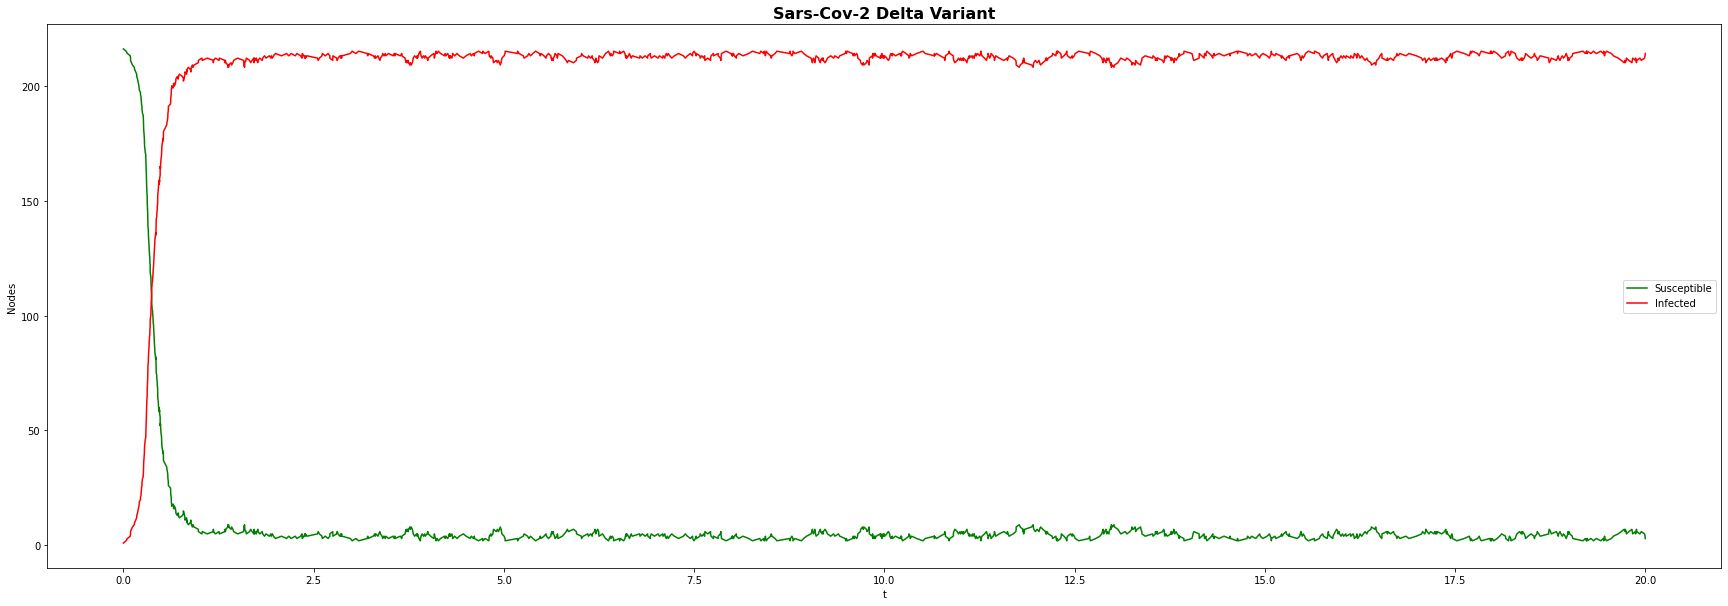

Peak: 215
Number of infected at least once: 215


In [778]:
sis_data_orig = EoN.fast_SIS(G, original_cov_tau, gamma, transmission_weight='weight',initial_infecteds=get_random_nodes(n_initial_infected), return_full_data=True)
sis_data_alpha = EoN.fast_SIS(G, alpha_cov_tau, gamma, transmission_weight='weight',initial_infecteds=get_random_nodes(n_initial_infected), tmax=20, return_full_data=True)
sis_data_delta = EoN.fast_SIS(G, delta_cov_tau, gamma, transmission_weight='weight',initial_infecteds=get_random_nodes(n_initial_infected), tmax=20, return_full_data=True)

display_linegraph(t=sis_data_orig.t(),S=sis_data_orig.S(),I=sis_data_orig.I(),title="Sars-Cov-2 Original")
print("Peak: " + str(max(sis_data_orig.I())))
print("Number of infected at least once: " + str(len(get_infected(sis_data_orig))))

display_linegraph(t=sis_data_alpha.t(),S=sis_data_alpha.S(),I=sis_data_alpha.I(),title="Sars-Cov-2 Alpha Variant")
print("Peak: " + str(max(sis_data_alpha.I())))
print("Number of infected at least once: " + str(len(get_infected(sis_data_orig))))

display_linegraph(t=sis_data_delta.t(),S=sis_data_delta.S(),I=sis_data_delta.I(),title="Sars-Cov-2 Delta Variant")
print("Peak: " + str(max(sis_data_delta.I())))
print("Number of infected at least once: " + str(len(get_infected(sis_data_delta))))

## Infecting hub first

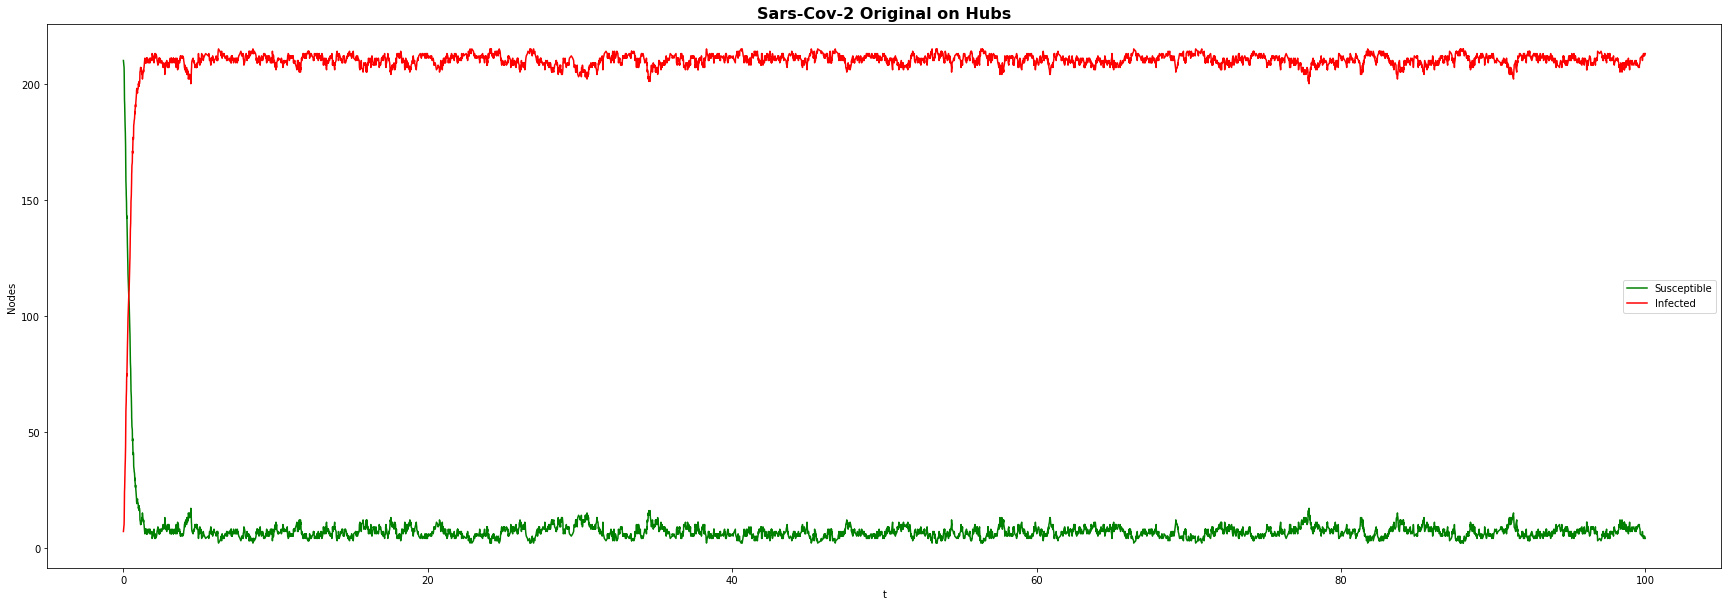

Peak: 215
Number of infected at least once: 215


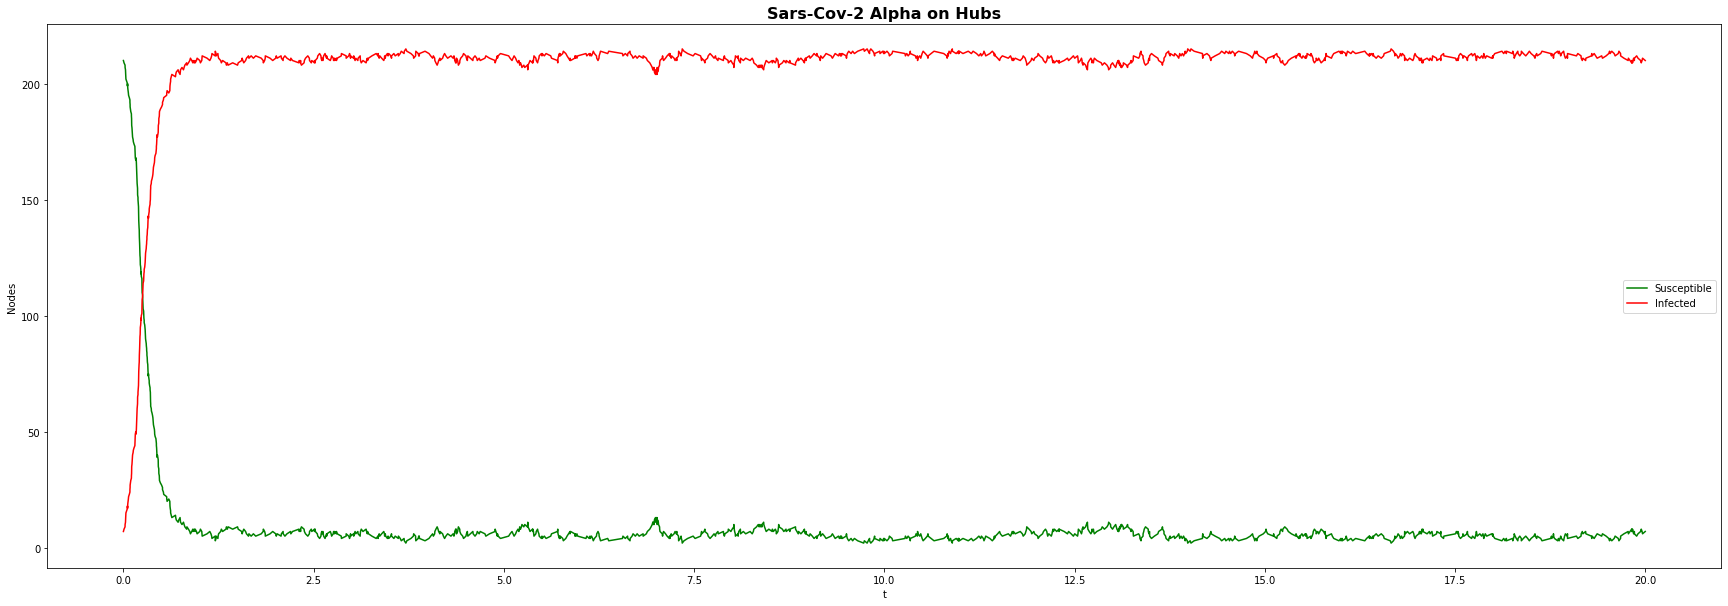

Peak: 215
Number of infected at least once: 215


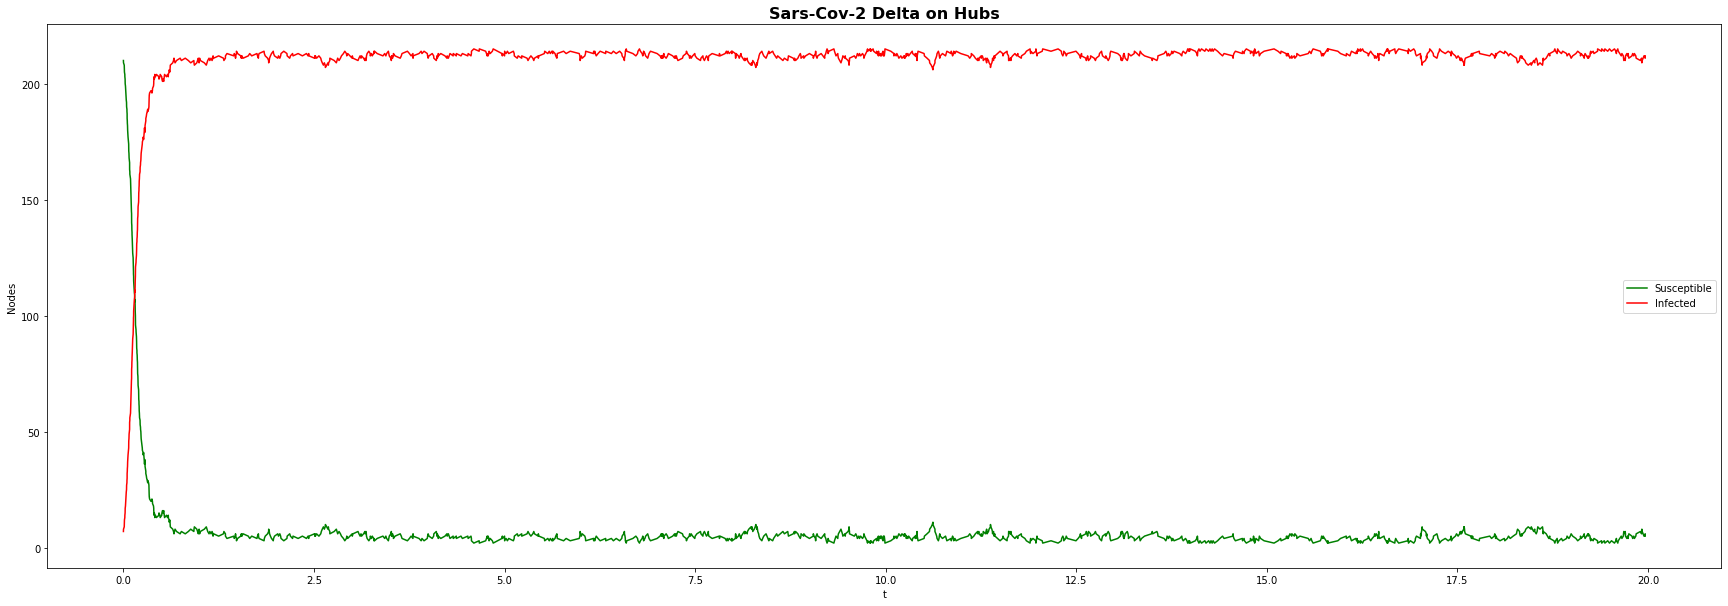

Peak: 215
Number of infected at least once: 215


In [758]:
sis_data_orig_hub = EoN.fast_SIS(G, original_cov_tau, gamma, transmission_weight='weight',initial_infecteds=max_out_degree_nodes, return_full_data=True)
sis_data_alpha_hub = EoN.fast_SIS(G, alpha_cov_tau, gamma, transmission_weight='weight',initial_infecteds=max_out_degree_nodes, tmax=20, return_full_data=True)
sis_data_delta_hub = EoN.fast_SIS(G, delta_cov_tau, gamma, transmission_weight='weight',initial_infecteds=max_out_degree_nodes, tmax=20, return_full_data=True)

display_linegraph(t=sis_data_orig_hub.t(),S=sis_data_orig_hub.S(),I=sis_data_orig_hub.I(),title="Sars-Cov-2 Original on Hubs")
print("Peak: " + str(max(sis_data_orig_hub.I())))
print("Number of infected at least once: " + str(len(get_infected(sis_data_orig_hub))))

display_linegraph(t=sis_data_alpha_hub.t(),S=sis_data_alpha_hub.S(),I=sis_data_alpha_hub.I(),title="Sars-Cov-2 Alpha on Hubs")
print("Peak: " + str(max(sis_data_alpha_hub.I())))
print("Number of infected at least once: " + str(len(get_infected(sis_data_alpha_hub))))

display_linegraph(t=sis_data_delta_hub.t(),S=sis_data_delta_hub.S(),I=sis_data_delta_hub.I(),title="Sars-Cov-2 Delta on Hubs")
print("Peak: " + str(max(sis_data_delta_hub.I())))
print("Number of infected at least once: " + str(len(get_infected(sis_data_delta_hub))))


In [759]:
#ani = sis_data.animate()
#ani.save('SIS.mp4', fps=5, extra_args=['-vcodec', 'libx264'])

## SIRS

In [760]:
#Documentation: https://epidemicsonnetworks.readthedocs.io/en/latest/examples/SIRS.html
#               https://epidemicsonnetworks.readthedocs.io/en/latest/functions/EoN.Gillespie_simple_contagion.html#EoN.Gillespie_simple_contagion

In [793]:
def run_sirs(gamma,mu,tau,initial_infected, initial_recovered=[], tmax=10,return_full_data=True):
    H = nx.DiGraph()  #DiGraph showing possible transitions that don't require an interaction
    H.add_edge('I', 'R', rate = gamma)   #I->R
    H.add_edge('R', 'S', rate = 1/mu)   #R->S

    J = nx.DiGraph()    #DiGraph showing transition that does require an interaction.
    J.add_edge(('I', 'S'), ('I', 'I'), rate = tau, weight_label='weight')  #IS->II

    IC = defaultdict(lambda: 'S')
    for node in initial_infected:
        IC[node] = 'I'

    for node in initial_recovered:
        IC[node] = 'R'    

    return_statuses = ('S', 'I', 'R')

    return EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses=return_statuses,tmax=tmax,return_full_data=return_full_data)

def run_sirsd(gamma,mu,tau,dr,initial_infected, initial_recovered=[], tmax=10,return_full_data=True):
    H = nx.DiGraph()  #DiGraph showing possible transitions that don't require an interaction
    H.add_edge('I', 'R', rate = gamma)   #I->R
    H.add_edge('I', 'D', rate = dr)   #I->D
    H.add_edge('R', 'S', rate = 1/mu)   #R->S


    J = nx.DiGraph()    #DiGraph showing transition that does require an interaction.
    J.add_edge(('I', 'S'), ('I', 'I'), rate = tau, weight_label='weight')  #IS->II

    IC = defaultdict(lambda: 'S')
    for node in initial_infected:
        IC[node] = 'I'

    for node in initial_recovered:
        IC[node] = 'R'    

    return_statuses = ('S', 'I', 'R','D')

    return EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses=return_statuses,tmax=tmax,return_full_data=return_full_data)


## Time series

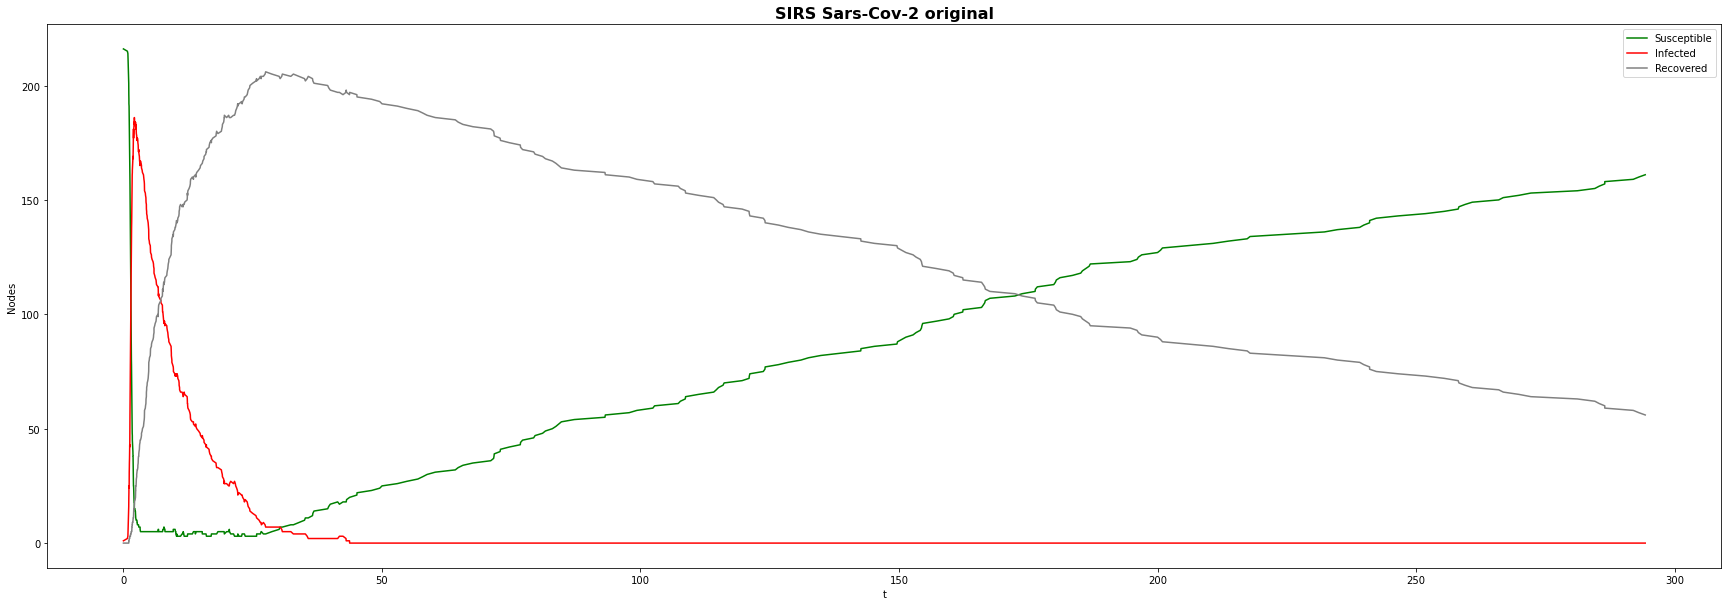

Peak: 186
Number of infected at least once: 214


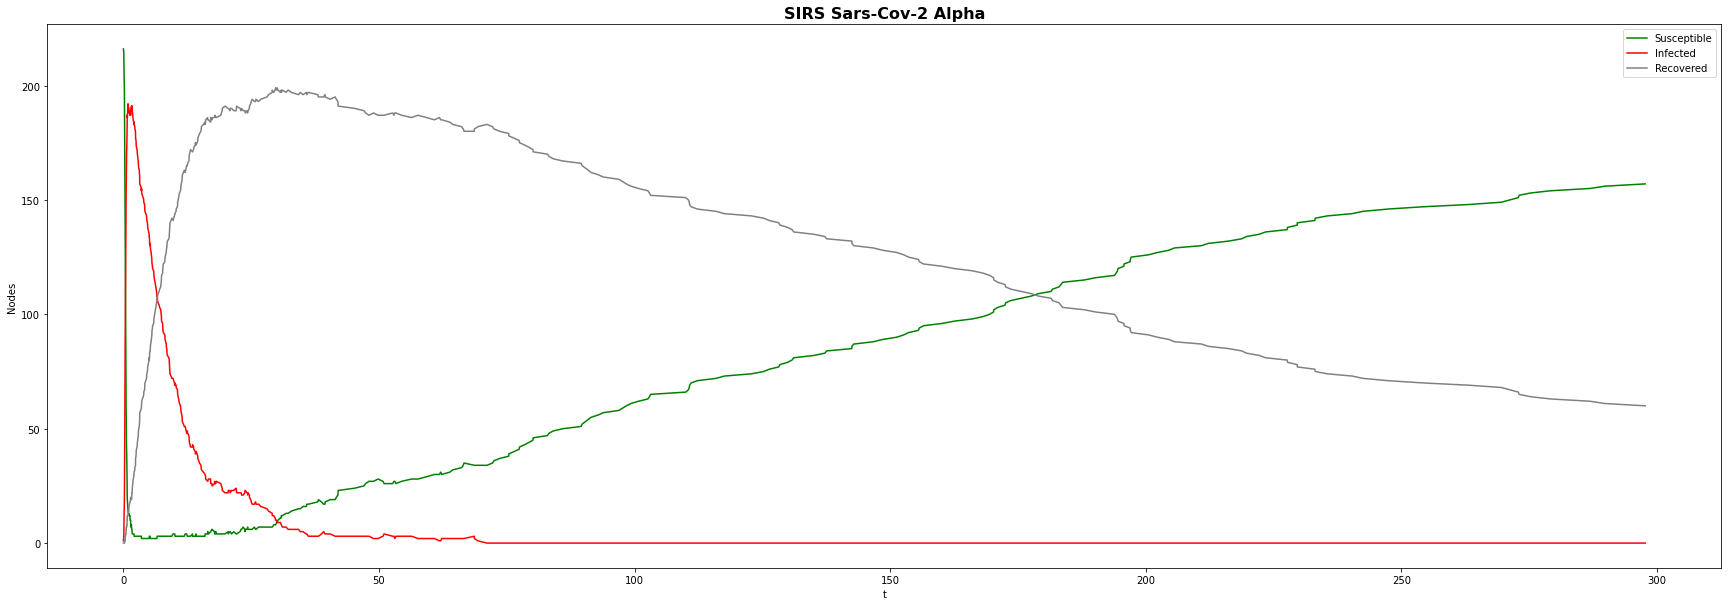

Peak: 192
Number of infected at least once: 215


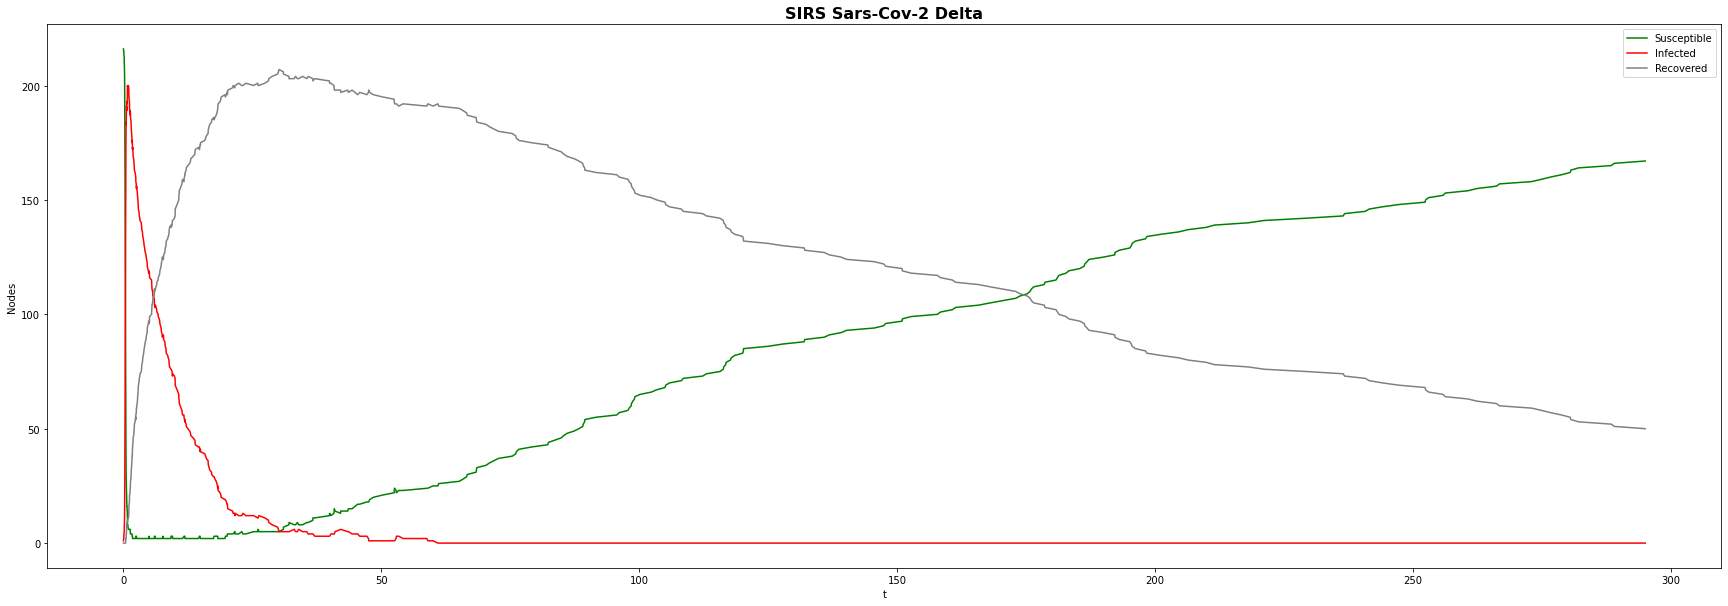

Peak: 200
Number of infected at least once: 215


In [787]:
sirs_orign_rnd= run_sirs(gamma,200,original_cov_tau,initial_infected=get_random_nodes(n_initial_infected), tmax=300, return_full_data=True)
display_linegraph(sirs_orign_rnd.t(), sirs_orign_rnd.S(), sirs_orign_rnd.I(), sirs_orign_rnd.R(),"SIRS Sars-Cov-2 original")
print("Peak: " + str(max(sirs_orign_rnd.I())))
print("Number of infected at least once: " + str(len(get_infected(sirs_orign_rnd))))

sirs_alpha_rnd= run_sirs(gamma,200,alpha_cov_tau,initial_infected=get_random_nodes(n_initial_infected), tmax=300, return_full_data=True)
display_linegraph(sirs_alpha_rnd.t(), sirs_alpha_rnd.S(), sirs_alpha_rnd.I(), sirs_alpha_rnd.R(),"SIRS Sars-Cov-2 Alpha")
print("Peak: " + str(max(sirs_alpha_rnd.I())))
print("Number of infected at least once: " + str(len(get_infected(sirs_alpha_rnd))))

sirs_delta_rnd = run_sirs(gamma,200,delta_cov_tau,initial_infected=get_random_nodes(n_initial_infected),tmax=300, return_full_data=True)
display_linegraph(sirs_delta_rnd.t(), sirs_delta_rnd.S(), sirs_delta_rnd.I(), sirs_delta_rnd.R(),"SIRS Sars-Cov-2 Delta")
print("Peak: " + str(max(sirs_delta_rnd.I())))
print("Number of infected at least once: " + str(len(get_infected(sirs_delta_rnd))))



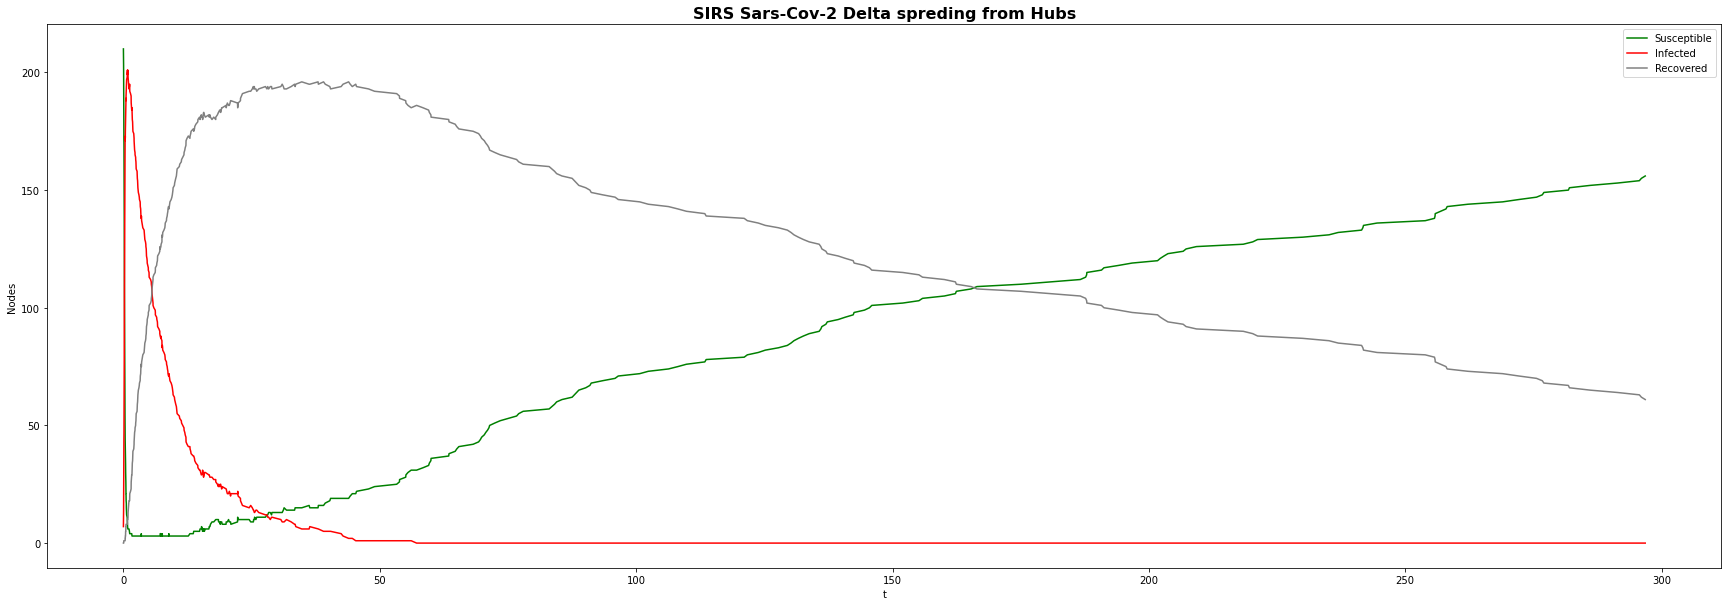

Peak: 201
Number of infected at least once: 214


In [785]:
sirs_delta_hubs = run_sirs(gamma,200,delta_cov_tau,initial_infected=max_out_degree_nodes, tmax=300, return_full_data=True)

display_linegraph(sirs_delta_hubs.t(), sirs_delta_hubs.S(), sirs_delta_hubs.I(), sirs_delta_hubs.R(),"SIRS Sars-Cov-2 Delta spreding from Hubs")
print("Peak: " + str(max(sirs_delta_hubs.I())))
print("Number of infected at least once: " + str(len(get_infected(sirs_delta_hubs))))

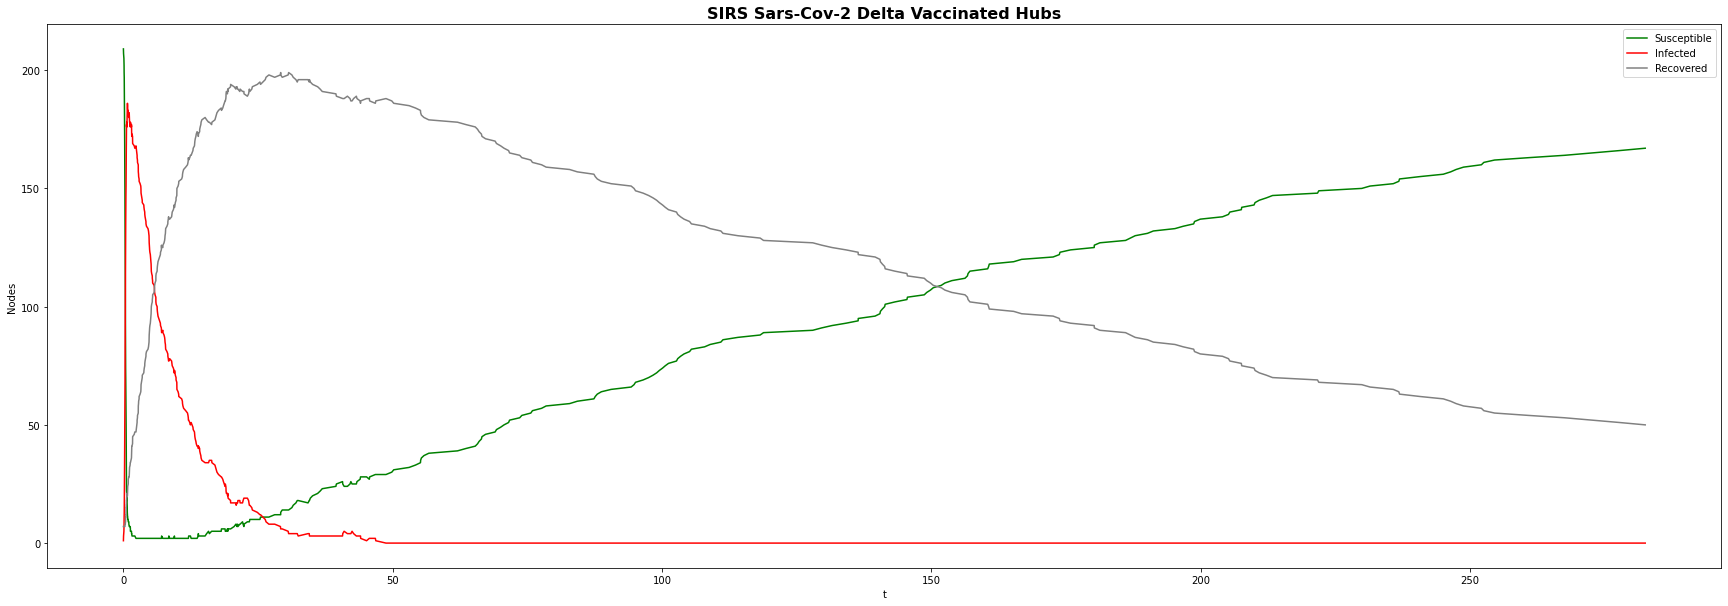

Peak: 186
Number of infected at least once: 211


In [784]:
sirs_delta_vax_hubs = run_sirs(gamma,200,delta_cov_tau,initial_infected=get_random_nodes(n_initial_infected,vaxed=max_out_degree_nodes), initial_recovered=max_out_degree_nodes, tmax=300, return_full_data=True)

display_linegraph(sirs_delta_vax_hubs.t(), sirs_delta_vax_hubs.S(), sirs_delta_vax_hubs.I(), sirs_delta_vax_hubs.R(),"SIRS Sars-Cov-2 Delta Vaccinated Hubs")
print("Peak: " + str(max(sirs_delta_vax_hubs.I())))
print("Number of infected at least once: " + str(len(get_infected(sirs_delta_vax_hubs))))

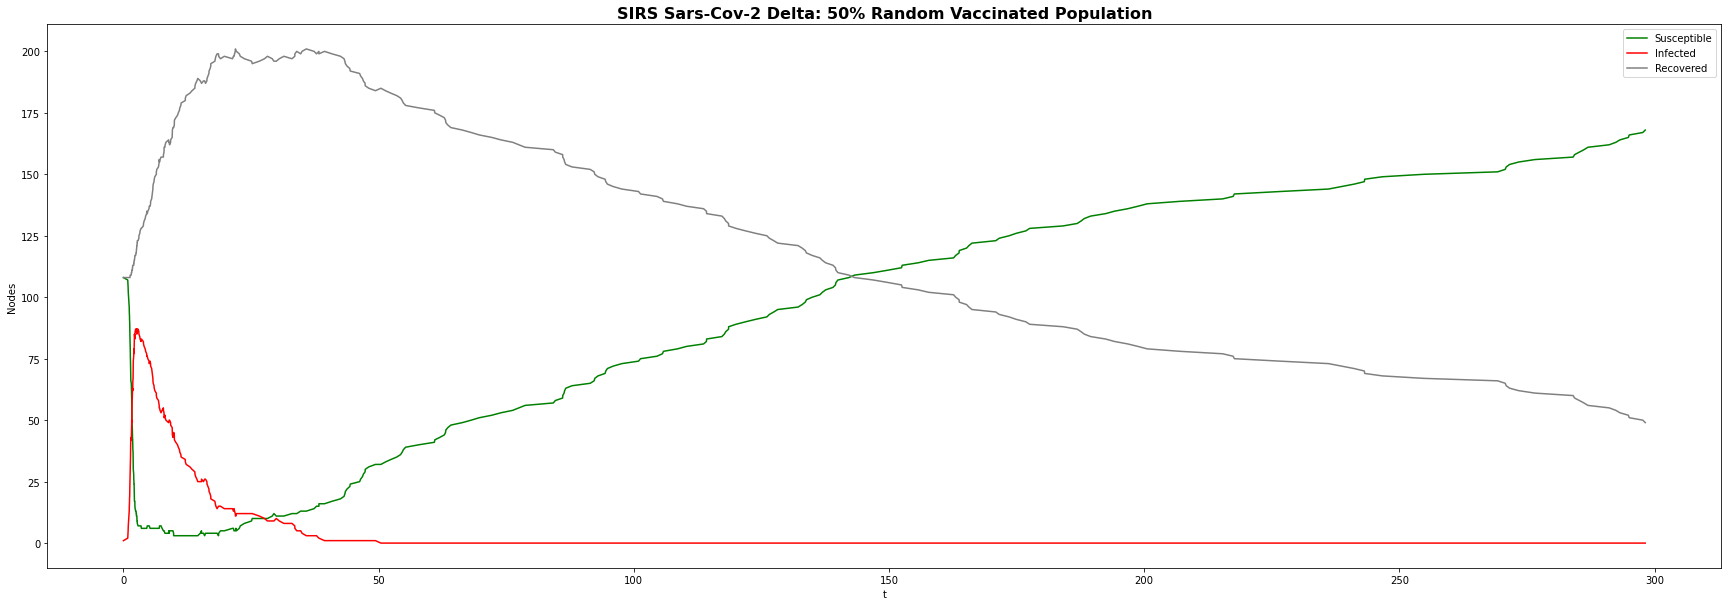

Peak: 87
Number of infected at least once: 114


In [783]:
random_infected, random_recovered = get_random_nodes(n_initial_infected,108)
sirs_delta_vax_pop = run_sirs(gamma,200,delta_cov_tau,initial_infected=random_infected,initial_recovered=random_recovered, tmax=300, return_full_data=True)

display_linegraph(sirs_delta_vax_pop.t(), sirs_delta_vax_pop.S(), sirs_delta_vax_pop.I(), sirs_delta_vax_pop.R(),"SIRS Sars-Cov-2 Delta: 50% Random Vaccinated Population")

print("Peak: " + str(max(sirs_delta_vax_pop.I())))
print("Number of infected at least once: " + str(len(get_infected(sirs_delta_vax_pop))))

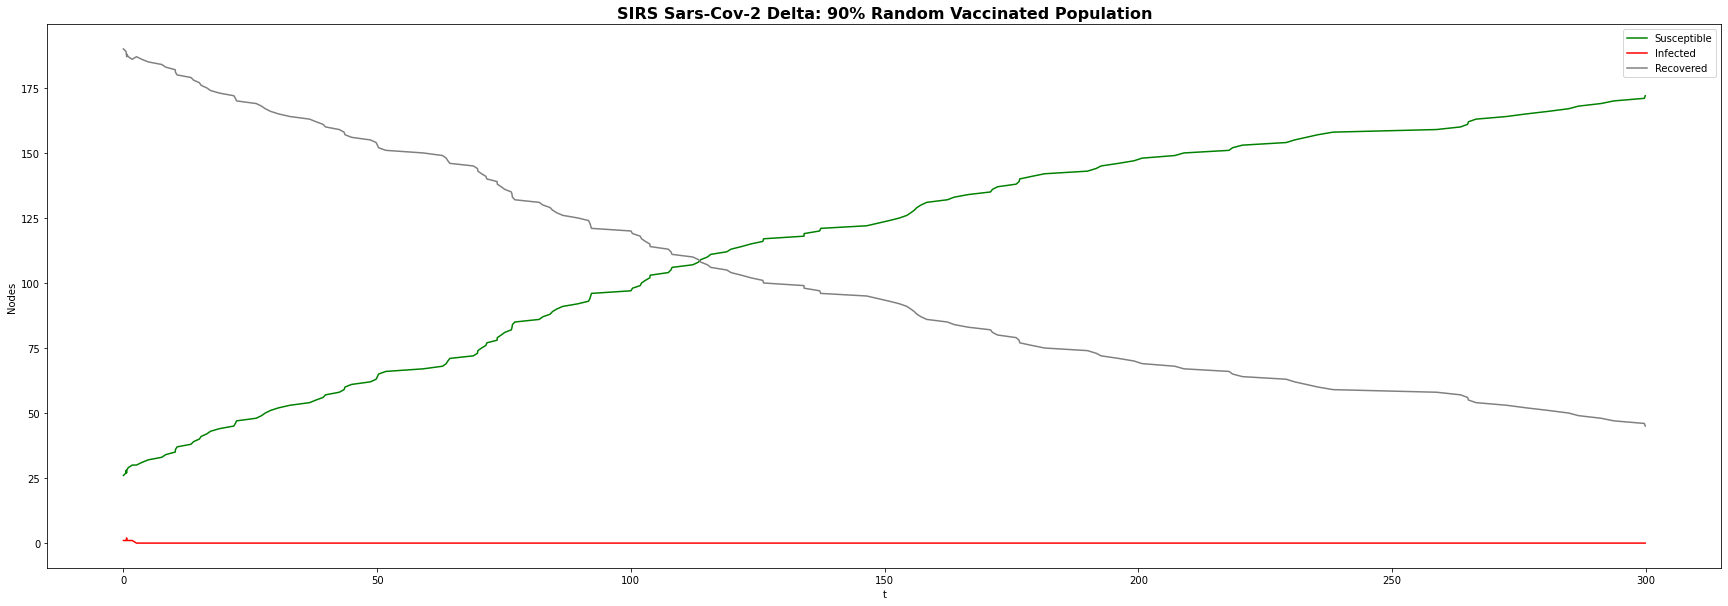

Peak: 2
Number of infected at least once: 2


In [782]:
random_infected, random_recovered = get_random_nodes(n_initial_infected,190)
sirs_delta_vax_pop = run_sirs(gamma,200,delta_cov_tau,initial_infected=random_infected,initial_recovered=random_recovered, tmax=300, return_full_data=True)

display_linegraph(sirs_delta_vax_pop.t(), sirs_delta_vax_pop.S(), sirs_delta_vax_pop.I(), sirs_delta_vax_pop.R(),"SIRS Sars-Cov-2 Delta: 90% Random Vaccinated Population")

print("Peak: " + str(max(sirs_delta_vax_pop.I())))
print("Number of infected at least once: " + str(len(get_infected(sirs_delta_vax_pop))))

## SIRSD

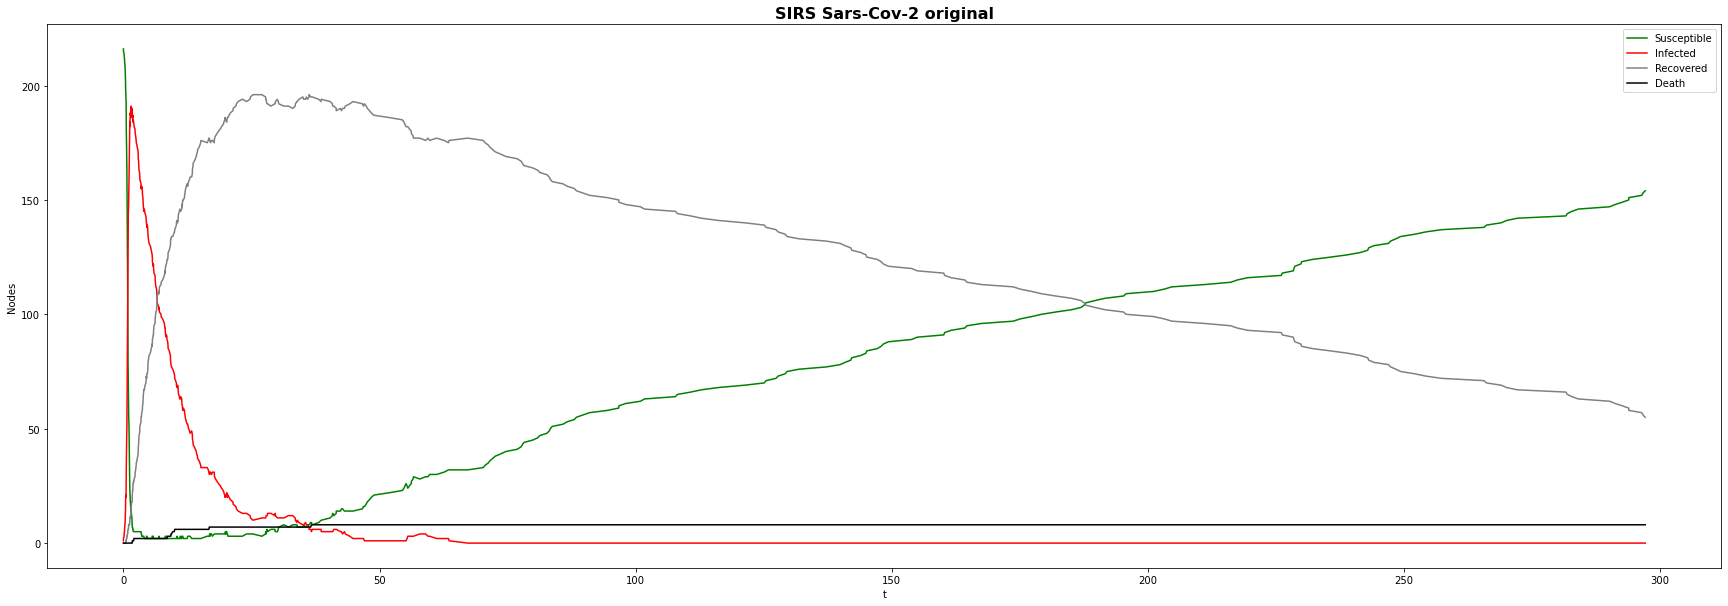

Peak: 191
Number of infected at least once: 191
Number of dead: 8


In [815]:
ifr = 0.006 #Infection Fatality Rate https://www.nature.com/articles/s41586-020-2918-0

t,S,I,R,D= run_sirsd(gamma,200,original_cov_tau,ifr,initial_infected=get_random_nodes(n_initial_infected), tmax=300, return_full_data=False)
#display_linegraph(sirsd_orign_rnd.t(), sirsd_orign_rnd.S(), sirsd_orign_rnd.I(), sirsd_orign_rnd.R(),sirsd_orign_rnd.D(), "SIRS Sars-Cov-2 original")

fig_sirs_ax = plt.figure(figsize=(30,10))
plt.plot(t, S, label = 'Susceptible', color='green')
plt.plot(t, I, label = 'Infected', color='red')
plt.plot(t, R, label = 'Recovered', color='grey')
plt.plot(t, D, label = 'Death', color='black')
plt.xlabel('t')
plt.ylabel('Nodes')
plt.legend()
plt.title("SIRSD Sars-Cov-2 original",fontsize=16,fontweight='bold')
plt.show()
plt.close(fig_sirs_ax)   

print("Peak: " + str(max(I)))

list_infected=[]

for node in G.nodes():
    if node in I:
        if not node in list_infected:
            list_infected.append(node)

print("Number of infected at least once: " + str(len(list_infected)))

list_dead=[]

for node in G.nodes():
    if node in D:
        if not node in list_dead:
            list_dead.append(node)

print("Number of dead: " + str(len(list_dead)))

In [769]:
# ani = sirs_delta_vax_pop.animate()
# ani.save('SIRS.mp4', fps=5, extra_args=['-vcodec', 'libx264'])